<a href="https://colab.research.google.com/github/vishes-i/-VISHESHCODSOFT/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Observation of ice melting : facade of the Eqi glacier

In [ ]:
# Planetary Computer, STAC
import pystac
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

# Stats and vector data
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely

# Image processing
import rasterio as rio
import rasterio.plot, rasterio.features, rasterio.mask, rasterio.fill  # Not loaded by default
import skimage.morphology, skimage.measure

# Plotting
import matplotlib.pyplot as plt
import IPython.display
import ipywidgets
import leafmap

# For nice HTML outputs
import rich.table

In [ ]:
%pip install pystac pystac-client planetary-computer geopandas shapely rasterio scikit-image matplotlib leafmap rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.2 MB/s eta 0:00:00


Environment


In [ ]:
plt.style.use('default')
folium_tile = "CartoDB Positron"

Import images from landsat
To search for the images that we will be studying, we'll use Planetary Computer Explorer because it is easier.

Oldest image to compare
The image that will be used is from 1985. We will call it before since it's the oldest image.

In [ ]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LT05_L2SP_011011_19850903_02_T1"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
before = planetary_computer.sign(item)

In [ ]:
before.assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LT05_L2SP_011011_19850903_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55&format=png'

In [ ]:
before;

In [ ]:
# preview of the image
IPython.display.Image(url=before.assets["rendered_preview"].href, width=800)

Latest image to compare
The latest image will be called after and is from 2022.

In [ ]:
# For 2022
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC08_L2SP_010011_20220801_02_T1"
#item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC09_L2SP_011011_20220715_02_T1"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
after = planetary_computer.sign(item)

In [ ]:
after.assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LC08_L2SP_010011_20220801_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55&format=png'

In [ ]:
# preview of the image
IPython.display.Image(url=after.assets["rendered_preview"].href, width=800)

Explore a dataset


In [ ]:
# Rich provides an easy way to build pretty HTML tables
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in before.assets.items():
    table.add_row(asset_key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Description                                                      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ qa               │ Surface Temperature Quality Assessment Band                      │
│ ang              │ Angle Coefficients File                                          │
│ red              │ Red Band                                                         │
│ blue             │ Blue Band                                                        │
│ drad             │ Downwelled Radiance Band                                         │
│ emis             │ Emissivity Band                                                  │
│ emsd             │ Emissivity Standard Deviation Band                               │
│ lwir             │ Surface Temperature Band                                         │
│ trad             │ Thermal Radiance Band                                            │
│ urad             │ Upwelled Radiance Band                                           │
│ atran            │ Atmospheric Transmittance Band                                   │
│ cdist            │ Cloud Distance Band                                              │
│ green            │ Green Band                                                       │
│ nir08            │ Near Infrared Band 0.8                                           │
│ swir16           │ Short-wave Infrared Band 1.6                                     │
│ swir22           │ Short-wave Infrared Band 2.2                                     │
│ mtl.txt          │ Product Metadata File (txt)                                      │
│ mtl.xml          │ Product Metadata File (xml)                                      │
│ cloud_qa         │ Cloud Quality Assessment Band                                    │
│ mtl.json         │ Product Metadata File (json)                                     │
│ qa_pixel         │ Pixel Quality Assessment Band                                    │
│ qa_radsat        │ Radiometric Saturation and Dropped Pixel Quality Assessment Band │
│ atmos_opacity    │ Atmospheric Opacity Band                                         │
│ tilejson         │ TileJSON with default rendering                                  │
│ rendered_preview │ Rendered preview                                                 │
└──────────────────┴──────────────────────────────────────────────────────────────────┘

In [ ]:
# Load full georeferenced false color (NIR) image with Leafmap
m = leafmap.Map()
m.add_stac_layer(
    collection="landsat-c2-l2",
    name=after.datetime.strftime('%Y.%m.%d'),
    item=after.id,
    assets=["nir08"])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Rasterio

In [ ]:
# Open a remote 8bit GeoTIFF dataset to fetch image geometry
with rio.open(before.assets["red"].href) as ds:
    profile_before = ds.profile

In [ ]:
with rio.open(after.assets["red"].href) as ds:
    profile_after = ds.profile

In [ ]:
# We can use the same profile dict for different bands since this 3 things are constant
rich.print(profile_before)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 8691,
    'height': 8271,
    'count': 1,
    'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 
84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG"
,"8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transver
se_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],
PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["East
ing",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32622"]]'),
    'transform': Affine(30.0, 0.0, 310185.0,
       0.0, -30.0, 7847715.0),
    'blockxsize': 256,
    'blockysize': 256,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [ ]:
rich.print(profile_after)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 8601,
    'height': 8641,
    'count': 1,
    'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 
84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG"
,"8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transver
se_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],
PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["East
ing",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32622"]]'),
    'transform': Affine(30.0, 0.0, 374985.0,
       0.0, -30.0, 7851015.0),
    'blockxsize': 256,
    'blockysize': 256,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [ ]:
# Let's keep a reference to the CRS
crs = profile_after['crs']

In [ ]:
# Map size
size = 1000

In [ ]:
# facade of the glacier coords
horizontal_coord = 528_980
vertical_coord = 7_743_000

In [ ]:
# Horizontal coord is 528_980
left_coord = horizontal_coord - (size/2) * 10
right_coord = horizontal_coord + (size/2) * 10

In [ ]:
# Top coordinates is 7_847_715
top_coord = vertical_coord + (size/2) * 10
bottom_coord = vertical_coord - (size/2) * 10

In [ ]:
warped_aoi_bounds = (left_coord,
                     bottom_coord,
                     right_coord,
                     top_coord
                    )
warped_aoi_bounds

(523980.0, 7738000.0, 533980.0, 7748000.0)

Define windows
We need to define different windows since the image size and location aren't the same

Before window

In [ ]:
# Round pixel size and offsets: we can't slice any array using floating points
aoi_window_before = rio.windows.from_bounds(*warped_aoi_bounds, transform=profile_before["transform"])
aoi_window_before = aoi_window_before.round_shape().round_offsets()
aoi_window_before

Window(col_off=7126, row_off=3323, width=333, height=333)

After window

In [ ]:
aoi_window_after = rio.windows.from_bounds(*warped_aoi_bounds, transform=profile_after["transform"])
aoi_window_after = aoi_window_after.round_shape().round_offsets()
aoi_window_after


Window(col_off=4966, row_off=3433, width=333, height=333)

Numpy array manipulations and plotting

In [ ]:
# Load 16bit data as numpy array, using rasterio to open remote COG file
def rio_stack(
    item: pystac.Item,
    band_list: list,
    window: rio.windows.Window = None
):
    """Load and stack different bands in a STAC item, return stacked array and geometry profile"""
    array_list = []
    # Collect arrays
    for band_id in band_list:
        url = item.assets[band_id].href
        with rasterio.open(url) as ds:
            profile = ds.profile
            data = ds.read(1, window=window)  # read(1) returns 2D array
            array_list.append(data)
    # Update metadata dict
    profile["count"] = len(array_list)
    if window is not None:
        # Update image geometry
        profile["transform"] = rio.windows.transform(window, profile["transform"])
        # ! Width and height are integer since we used aoi_window.round_shape() !
        profile["width"], profile["height"] = window.width, window.height

    # N.B. this function is valid if only if all bands have the same geometry
    return np.stack(array_list), profile

In [ ]:
# We can stack all bands since their resolution is the same
array_before, profile = rio_stack(before, ["red", "green", "blue", "nir08", "swir22"], aoi_window_before)
array_after, _ = rio_stack(after, ["red", "green", "blue", "nir08", "swir22"], aoi_window_after)

# Make sure to check the profile dict
rich.print(profile)


{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 333,
    'height': 333,
    'count': 5,
    'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 
84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG"
,"8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transver
se_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],
PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["East
ing",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32622"]]'),
    'transform': Affine(30.0, 0.0, 523965.0,
       0.0, -30.0, 7748025.0),
    'blockxsize': 256,
    'blockysize': 256,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [ ]:
array_before.max(), array_after.max()

(np.uint16(65535), np.uint16(54557))

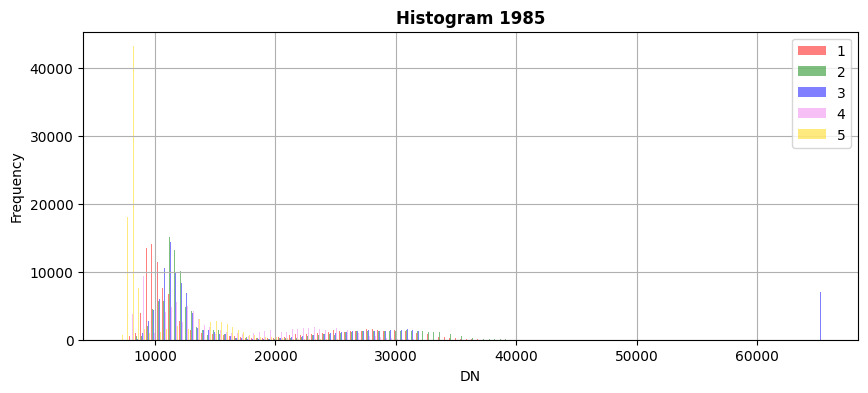

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_before, bins=128, stacked=False, alpha=0.5, title="Histogram 1985")

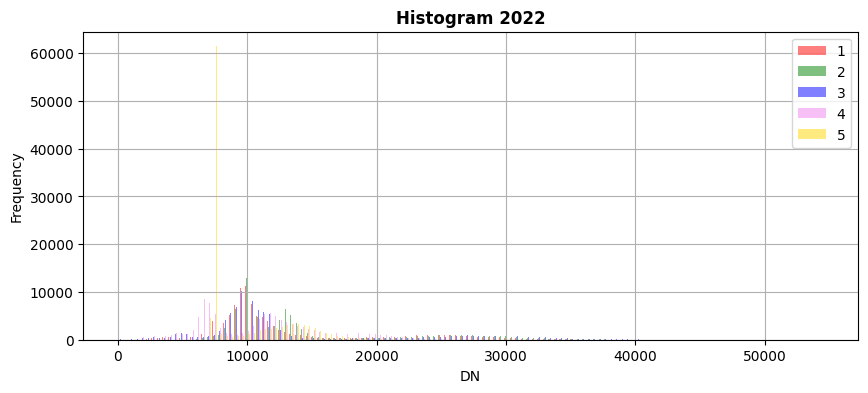

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_after, bins=128, stacked=False, alpha=0.5, title="Histogram 2022")

In [ ]:
# # Write raster data (always make sure your profile dict is correct)
# img_path = before.id + "_RGB_NIR.tif"
# # Open in "write" mode, here you may pass other params for GDAL as kwargs (after **profile)
# with rasterio.open(img_path, "w", **profile) as w:
#     w.write(array_before)

In [ ]:
array_reshaped = array_before.reshape([5, -1])  # or array_before.reshape([4, 2095*1260])
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1))

Min:  [7801 8161 8318 7361 6899]
Max:  [52532 55523 65535 43676 29988]
Mean [15928.94579264 17193.38212086 18944.94709124 14431.77512648
 10191.34397461]
Std [ 8072.32179916  8413.10669275 13980.10775466  6124.64648307
  3485.90640182]


In [ ]:
array_reshaped = array_after.reshape([5, -1])  # or array_before.reshape([4, 2095*1260])
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1))

Min:  [   0    0    0 1482 7069]
Max:  [49778 52236 54557 34618 25340]
Mean [13135.2375168  14490.28592557 13667.79672465 11204.7889421
  9747.82210138]
Std [6769.22588069 7026.85159387 8057.66994389 4760.1916184  3345.25442736]


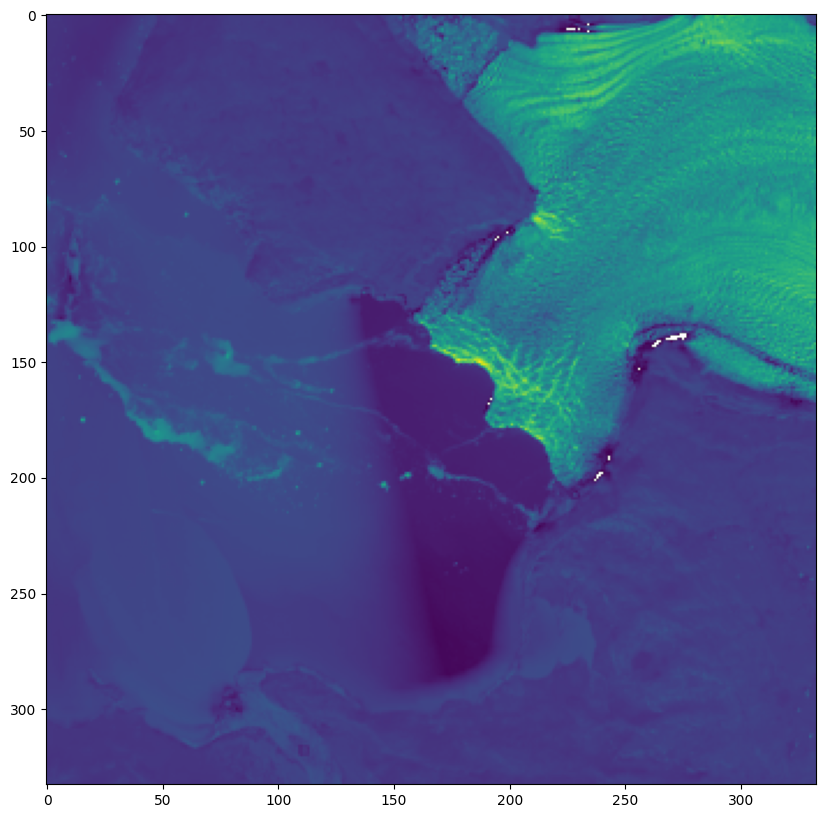

In [ ]:
with rasterio.open(after.assets['blue'].href) as ds:
    profile = ds.profile
    mask = ds.read_masks(window=aoi_window_after)
    data = ds.read(window=aoi_window_after)

# Let's build a numpy masked array. We need to invert it since GDAL and Numpy aren't using the same convention
mask = ~mask.astype(bool)

# Build a mask, we decide to fill missing values with the dataset declared nodata value (e.g. zero)
masked_data = np.ma.masked_array(data, mask, fill_value=profile['nodata'])

# Plot
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(masked_data[0])

In [ ]:
# Use slicing to get first bands (Keep RGB)
array_3b_before, array_3b_after = array_before[:3], array_after[:3]
array_3b_before.shape, array_3b_after.shape

((3, 333, 333), (3, 333, 333))

In [ ]:
new_array_before = np.moveaxis(array_3b_before, 0, 2)
new_array_before = np.interp(new_array_before, (1000, 30000), (0, 255))

In [ ]:
new_array_after = np.moveaxis(array_3b_after, 0, 2)
new_array_after = np.interp(new_array_after, (1000, 30000), (0, 255))

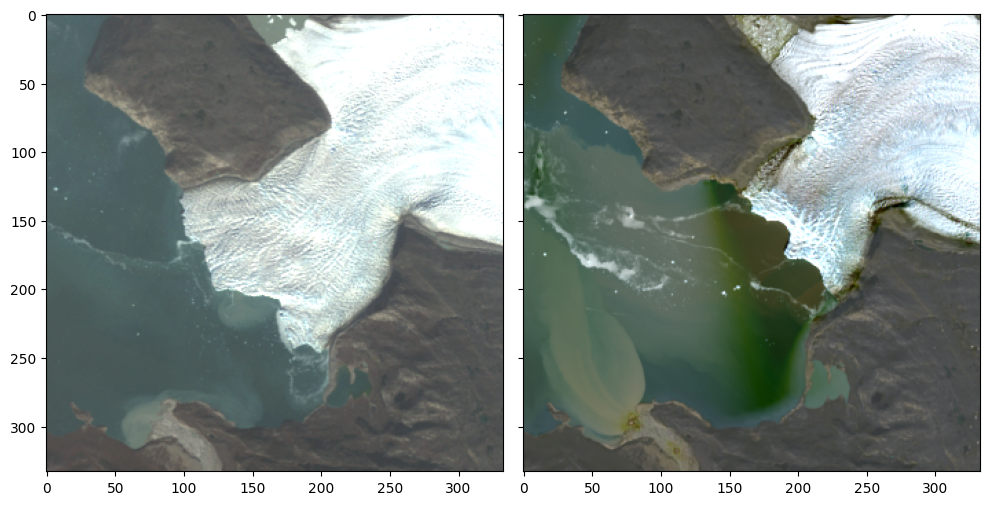

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,10), sharey=True, layout='tight')
axes[0].imshow(new_array_before.astype('uint8'))
axes[1].imshow(new_array_after.astype('uint8'));

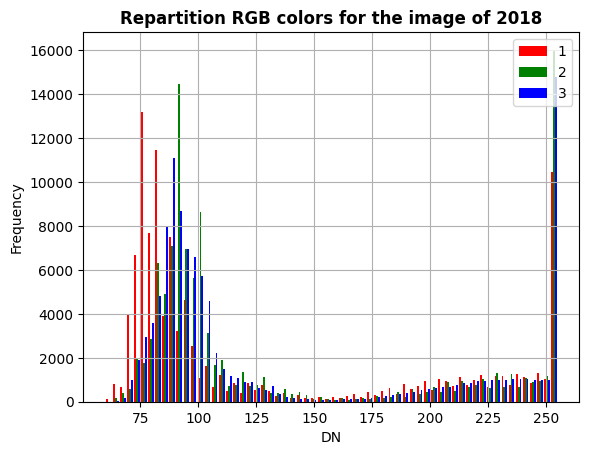

In [ ]:
rio.plot.show_hist(rio.plot.reshape_as_raster(new_array_before), bins=64,title="Repartition RGB colors for the image of 2018")

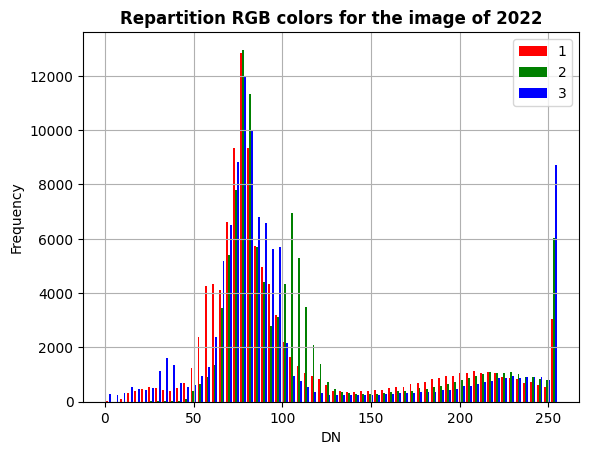

In [ ]:
rio.plot.show_hist(rio.plot.reshape_as_raster(new_array_after), bins=64,title="Repartition RGB colors for the image of 2022")

Rebuild the image with RGB bands

In [ ]:
# If you ever need to build a rendered (encoded) image object from a numpy array (usable with IPython.display.Image), you can use PIL
import PIL
def pil_image_from_array(array, target_width=None):
    """Build PIL image object from a numpy array, optional image transform to target width"""
    # Another way to change bands order
    array = np.transpose(array, axes=[1, 2, 0])
    img = PIL.Image.fromarray(array)
    if not target_width:
        return img
    w, h = img.size[0], img.size[1]
    aspect = w / h
    target_height = (int)(target_width / aspect)
    return img.resize((target_width, target_height), PIL.Image.Resampling.BILINEAR)

In [ ]:
# Need to change the format
new_array_after = new_array_after.astype(np.uint8)

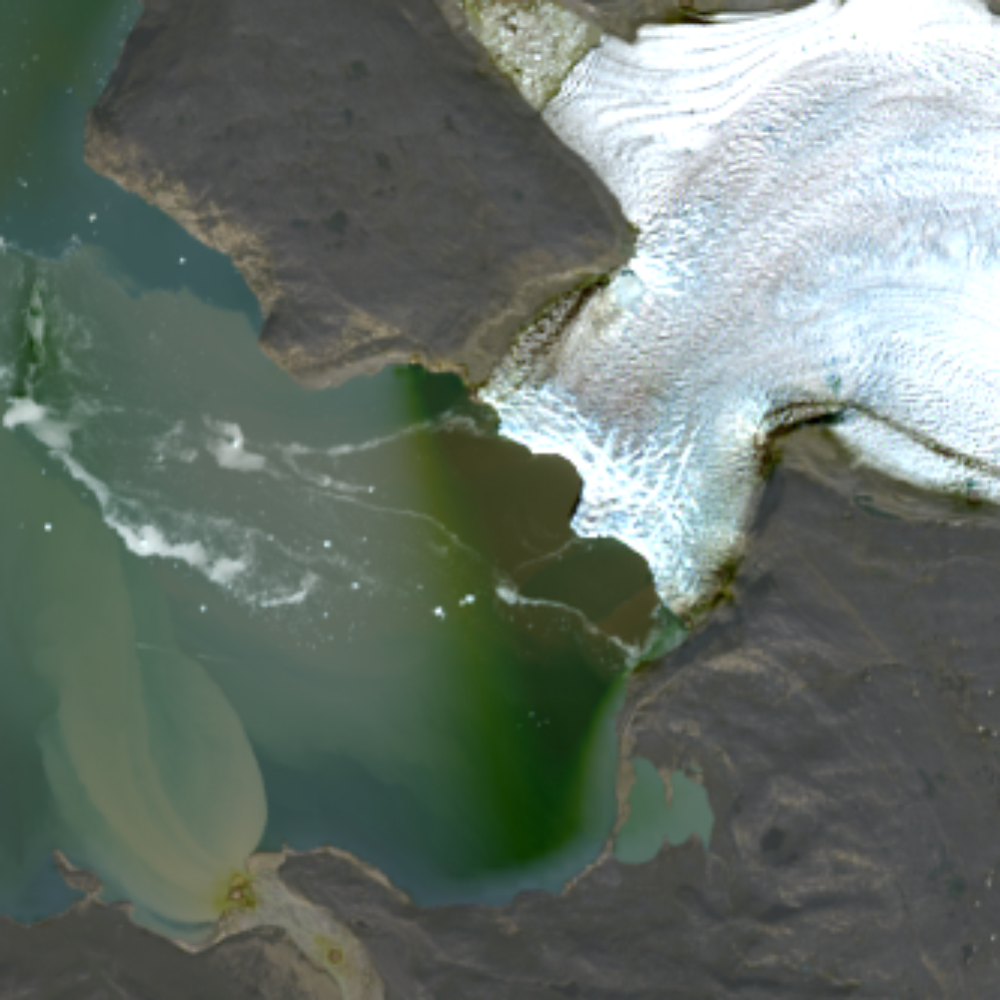

In [ ]:
# We need to transpose the array (0, 1, 2) to (2, 0, 1)
pil_image_from_array(
    np.transpose(new_array_after, (2, 0, 1)),
    target_width=1000
)

In [ ]:
del new_array_before, new_array_after

Stack bands
We need to compute the various bands.

Since the red, green, blue, nir and swir bands have the same resolution, we don't have to resample them.

In [ ]:
def get_s2_bands(item: pystac.Item, window: rasterio.windows.Window = None):
    array, profile = rio_stack(item, ["red", "blue", "green", "nir08", "swir22"], window)
    return array, profile

In [ ]:
get_s2_bands(before, aoi_window_before)[0].shape

(5, 333, 333)

Index & Compute
There are various indexes. The one most interesting for our case is the NDSI which is the Normalized Difference Snow Index.

In [ ]:
def compute_ndsi(array: np.ndarray):
    array = array.astype(np.float32)
    green, swir = array[1], array[4]
    return (green - swir) / (green + swir)

In [ ]:
array_before, profile = get_s2_bands(before, window=aoi_window_before)
array_after, _ = get_s2_bands(after, window=aoi_window_after)

In [ ]:
ndsi_before, ndsi_after = compute_ndsi(array_before), compute_ndsi(array_after)

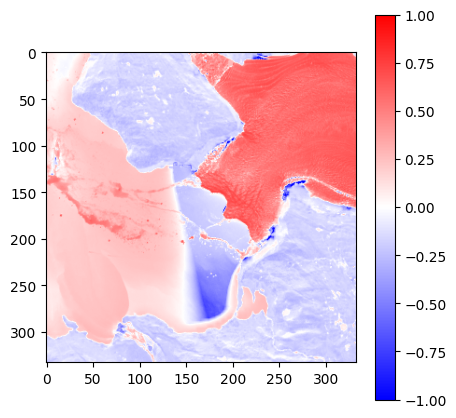

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ndsi_after, vmin=-1, vmax=1, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

In [ ]:
# We must to apply a mask to delete the blue part
ndsi_after[ndsi_after < 0.15] = 0.2

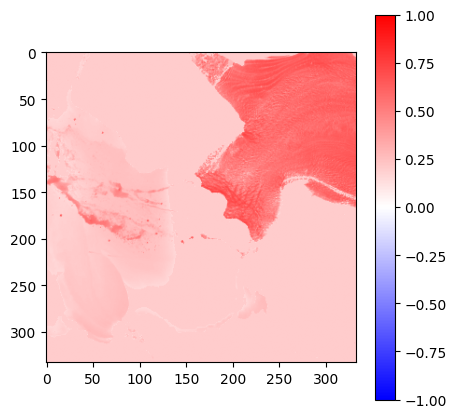

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ndsi_after, vmin=-1, vmax=1, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

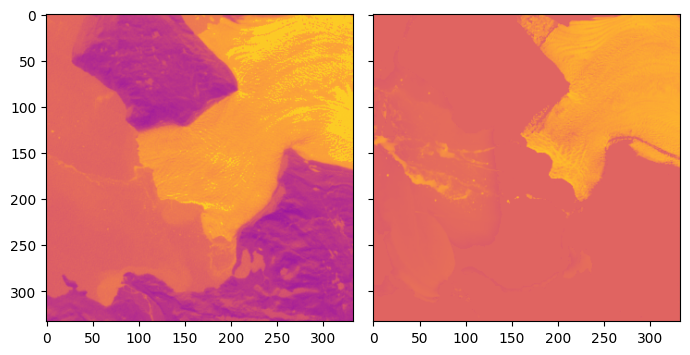

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharey=True, layout='tight')
axes[0].imshow(ndsi_before, vmin=-1, vmax=1, cmap="plasma", interpolation="bilinear")
axes[1].imshow(ndsi_after, vmin=-1, vmax=1, cmap="plasma", interpolation="bilinear");

In [ ]:
dndsi = ndsi_before - ndsi_after

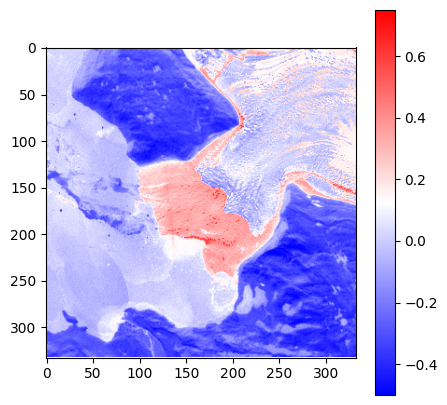

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(dndsi, vmin=-0.5, vmax=0.75, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

All in one function

In [ ]:

def get_dndsi(before: pystac.Item, after: pystac.Item, window: rasterio.windows.Window = None):
    array_before, profile = get_s2_bands(before, window=aoi_window_before)
    array_after, profile = get_s2_bands(after, window=aoi_window_after)
    ndsi_before, ndsi_after = compute_ndsi(array_before), compute_ndsi(array_after)
    # Apply mask
    ndsi_after[ndsi_after < 0.15] = 0.2
    dndsi = ndsi_before - ndsi_after
    profile.update({"dtype": "float32", "count": 1})
    return dndsi, profile

In [ ]:
dndsi, profile = get_dndsi(before, after)

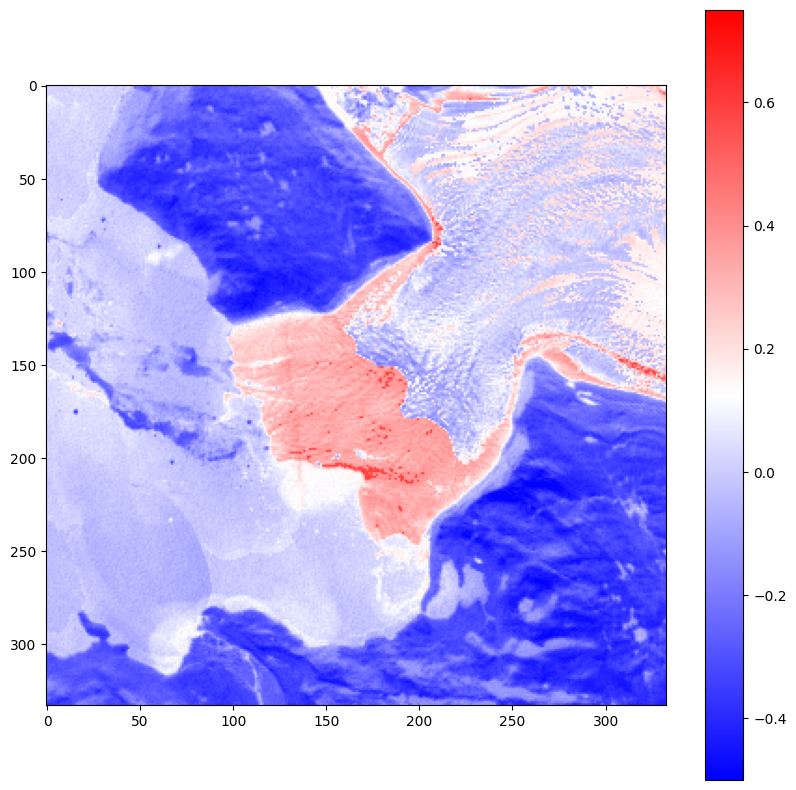

In [ ]:

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi, vmin=-0.5, vmax=0.75, cmap='bwr')
fig.colorbar(ax.get_children()[0]);

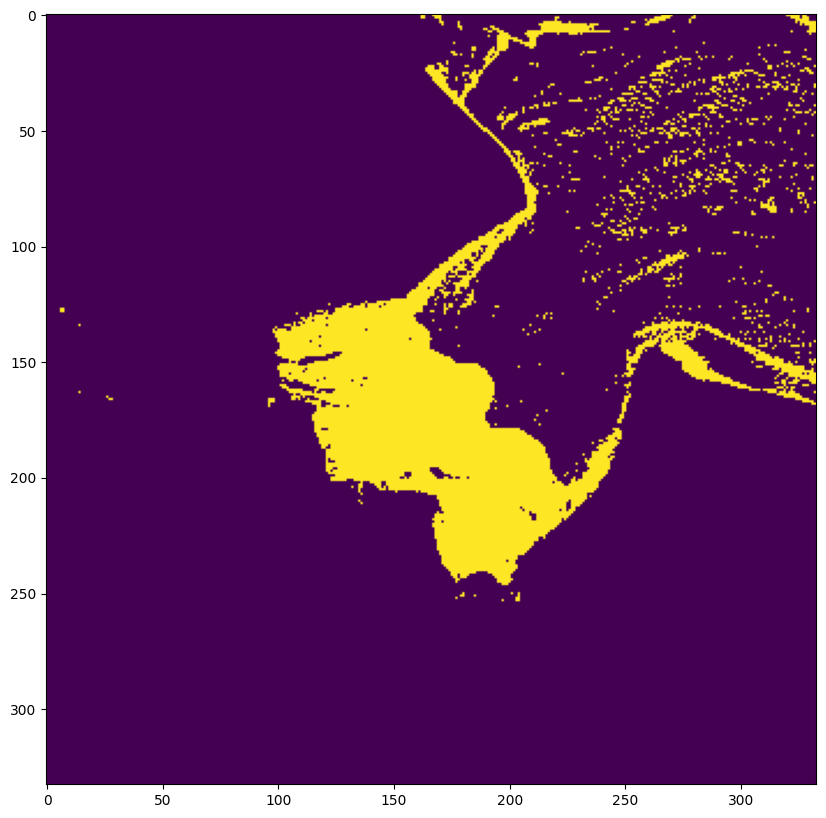

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi > 0.2);

In [ ]:
profile.update({"compress": "lzw", "nodata": None})  # Use LZW compression. Unset nodata.
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 333, 'height': 333, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32622"]]'), 'transform': Affine(30.0, 0.0, 523965.0,
       0.0, -30.0, 7748025.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [ ]:
thresholds = [-0.3, -0.15, 0, 0.1, 0.20, 0.25, 0.5]

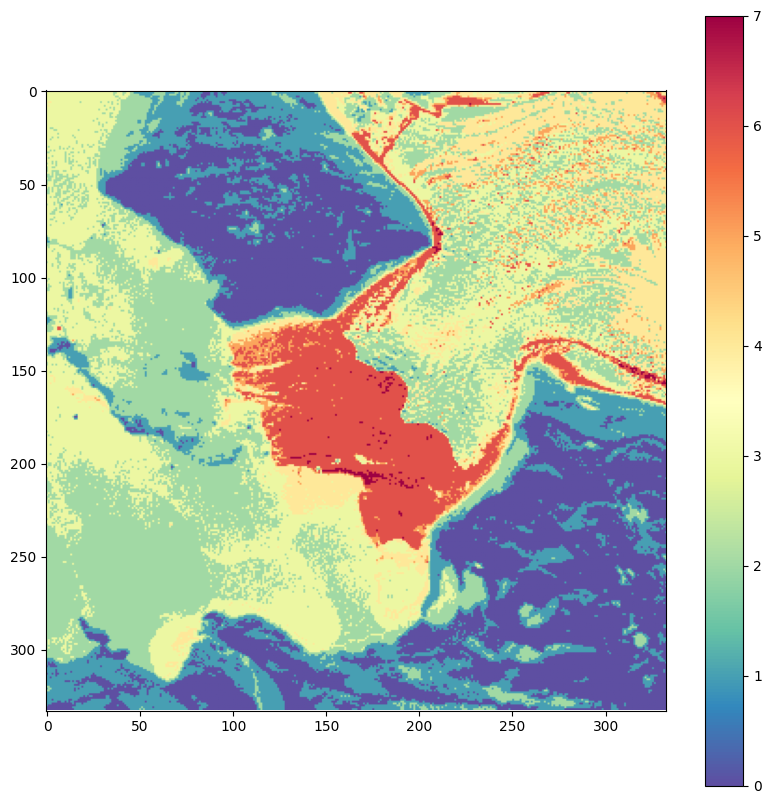

In [ ]:
reclassified_dndsi = np.digitize(dndsi, thresholds).astype("uint8")
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reclassified_dndsi, cmap='Spectral_r')
fig.colorbar(ax.get_children()[0])

In [ ]:
thresholds = [-0.2, -0.1, 0.20]

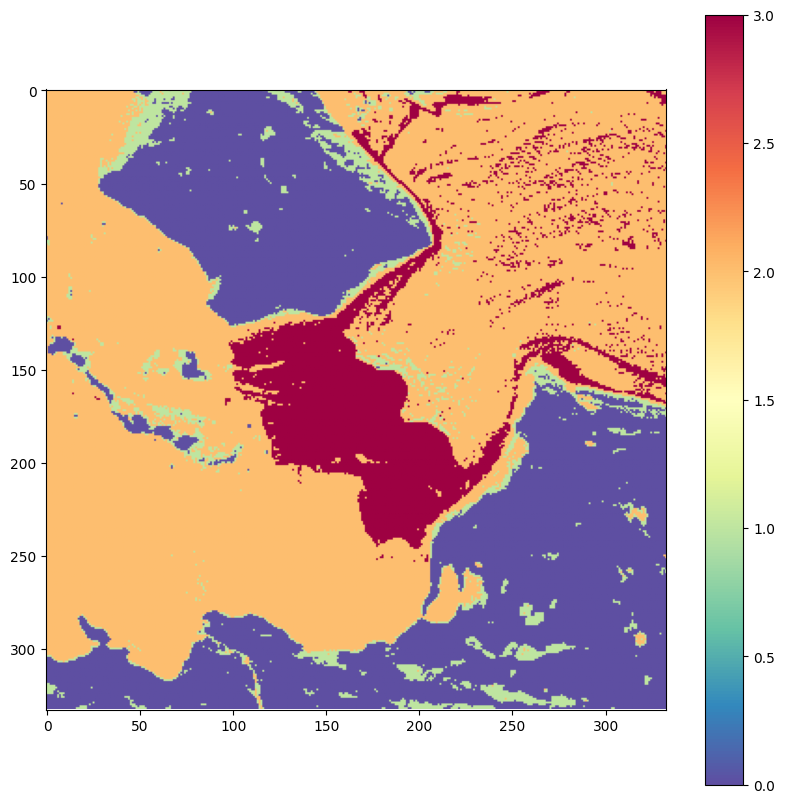

In [ ]:
reclassified_dndsi = np.digitize(dndsi, thresholds).astype("uint8")
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reclassified_dndsi, cmap='Spectral_r')
fig.colorbar(ax.get_children()[0])

Vectorize raster blobs

In [ ]:
geoms, values = [], []
# We create a list of shapes using source image transform
for geom, value in rio.features.shapes(
    reclassified_dndsi,
    transform=profile['transform'],
    mask=(reclassified_dndsi > 2.0),  # also we can mask some values
):
    geoms.append(shapely.geometry.shape(geom))
    values.append(value)

In [ ]:
# Create pandas series with our data lists: polygons and pixel values
geoms = gpd.GeoSeries(geoms)
values = pd.Series(values)

In [ ]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(values.rename("dNBR_class"), geometry=geoms, crs=crs)
gdf["area_ha"] = gdf.area / 10_000
print("Number of polygons :", len(gdf))

Number of polygons : 775


In [ ]:
# We have a lot of isloated pixels. It's better to remove them or leafmap will take too long to render
gdf.sort_values("area_ha").head()

dNBR_class                                           geometry  area_ha
18         3.0  POLYGON ((533415 7747635, 533415 7747605, 5334...     0.09
19         3.0  POLYGON ((531285 7747605, 531285 7747575, 5313...     0.09
20         3.0  POLYGON ((532125 7747605, 532125 7747575, 5321...     0.09
21         3.0  POLYGON ((533205 7747605, 533205 7747575, 5332...     0.09
23         3.0  POLYGON ((531195 7747575, 531195 7747545, 5312...     0.09

In [ ]:
gdf = gdf[gdf.area_ha >= 2]
print("Number of polygons :", len(gdf))

Number of polygons : 11


In [ ]:
import matplotlib.pyplot as plt
import mapclassify
# Explore
gdf.explore("dNBR_class", tiles=folium_tile, cmap="copper_r", style_kwds={"stroke": None})

In [ ]:
%pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 16.4 MB/s eta 0:00:00


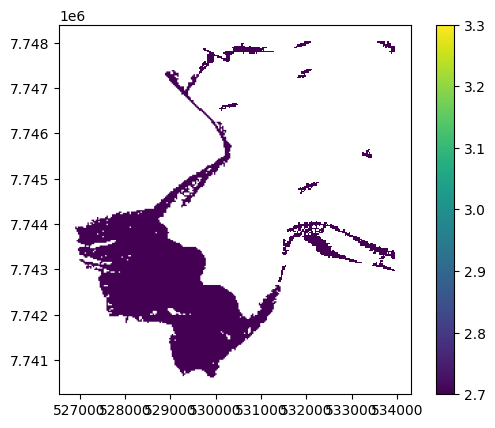

In [ ]:
# Plot it (To see it on Github)
fig, ax = plt.subplots(1, 1)
gdf.plot(column='dNBR_class', ax=ax, legend=True);

In [ ]:
# We drop the class to keep only the area surface
gdf.drop(['dNBR_class'], axis=1, inplace=True)

Comparison with initial image
With before picture

In [ ]:

m = leafmap.Map()
m.add_stac_layer(collection="landsat-c2-l2",
                 item=before.id,
                 assets=["nir08"],
                 opacity=0.6
                ),
m.add_gdf(
    gdf,
    fill_colors=["red"],
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

With recent image

In [ ]:
m = leafmap.Map()
m.add_stac_layer(collection="landsat-c2-l2",
                 item=after.id,
                 assets=["nir08"],
                 opacity=0.6
                ),
m.add_gdf(
    gdf,
    fill_colors=["red"],
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Conclusion


In [ ]:
# surface of melted ice (in ha)
melted_area = gdf["area_ha"].sum()

In [ ]:
print("The total area of ice that has melted over the observed area is", round(melted_area, 1), "ha")

The total area of ice that has melted over the observed area is 913.8 ha


We can see that the total area of ice that has melted over the observed area is 913.8 ha between the two images.

Therefore, there are 913.8 ha that has melted between 1985 and 2022.

In [ ]:
football_pitch = 0.714 # in ha
melted_area_in_football_pitch = melted_area / football_pitch

In [ ]:
print("The melted surface of ice corresponds to", round(melted_area_in_football_pitch, 1), "football pitch !")

The melted surface of ice corresponds to 1279.8 football pitch !


The values are approximation but overall, we notice that a large amount of ice has melted.

It is true that it is difficult to really realize the size of the glacier. Just imagine a wall that is over 100m high and over 4km wide!

Also, this study shows only the lost surface that is visible, a large part of the glacier is under water. The glacier has globally lost a lot of height. The quantities of ice that have melted are astronomical and the Eqi glacier represents only a very small part of the North Pole.

Let's take care of our Earth

In [ ]:
# surface of melted ice (in ha)
melted_area = gdf["area_ha"].sum()

In [ ]:
print("The total area of ice that has melted over the observed area is", round(melted_area, 1), "ha")

The total area of ice that has melted over the observed area is 913.8 ha


In [ ]:
football_pitch = 0.714 # in ha
melted_area_in_football_pitch = melted_area / football_pitch

In [ ]:
print("The melted surface of ice corresponds to", round(melted_area_in_football_pitch, 1), "football pitch !")

The melted surface of ice corresponds to 1279.8 football pitch !


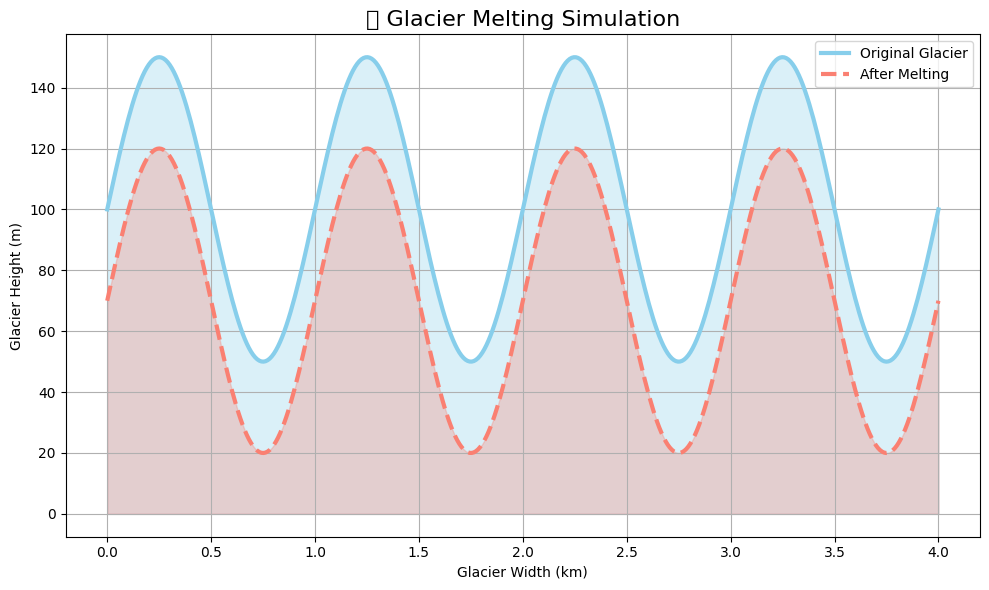

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample 2D elevation data (like a glacier cross-section)
x = np.linspace(0, 4, 400)
y = np.sin(2 * np.pi * x) * 50 + 100  # Original glacier height

# Simulate melting (loss of height)
melt_amount = 30
y_melted = y - melt_amount

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Original Glacier", color="skyblue", linewidth=3)
plt.plot(x, y_melted, label="After Melting", color="salmon", linestyle='--', linewidth=3)

# Fill under the curves
plt.fill_between(x, y, color="skyblue", alpha=0.3)
plt.fill_between(x, y_melted, color="salmon", alpha=0.3)

# Labels and title
plt.title("📉 Glacier Melting Simulation", fontsize=16)
plt.xlabel("Glacier Width (km)")
plt.ylabel("Glacier Height (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


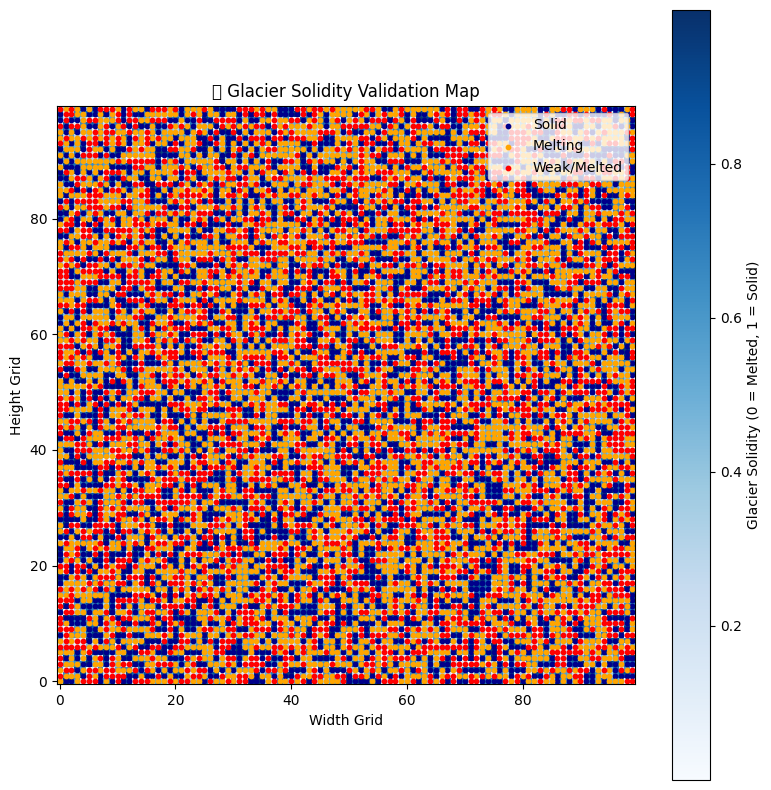

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a glacier grid (100x100 points)
np.random.seed(42)
grid_size = 100

# Random 'solidity' values between 0 (melted) and 1 (solid)
solidity = np.random.rand(grid_size, grid_size)

# Define categories based on solidity thresholds
solid_mask = solidity > 0.7
melting_mask = (solidity <= 0.7) & (solidity > 0.3)
weak_mask = solidity <= 0.3

# Plotting the glacier solidity map
plt.figure(figsize=(8, 8))
plt.imshow(solidity, cmap='Blues', origin='lower')
plt.colorbar(label='Glacier Solidity (0 = Melted, 1 = Solid)')
plt.title('🧊 Glacier Solidity Validation Map')

# Overlay points
solid_y, solid_x = np.where(solid_mask)
melting_y, melting_x = np.where(melting_mask)
weak_y, weak_x = np.where(weak_mask)

plt.scatter(solid_x, solid_y, color='darkblue', s=10, label='Solid')
plt.scatter(melting_x, melting_y, color='orange', s=10, label='Melting')
plt.scatter(weak_x, weak_y, color='red', s=10, label='Weak/Melted')

plt.legend(loc='upper right')
plt.xlabel("Width Grid")
plt.ylabel("Height Grid")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Sample glacier melting data by country code
data = [
    {"Country Code": "GL", "Glacier": "Eqi Glacier", "Melt Volume (km³)": 12.3, "Solidity Index": 0.45, "Status": "Melting"},
    {"Country Code": "US", "Glacier": "Mendenhall", "Melt Volume (km³)": 4.7, "Solidity Index": 0.35, "Status": "Melting"},
    {"Country Code": "CH", "Glacier": "Aletsch", "Melt Volume (km³)": 3.2, "Solidity Index": 0.28, "Status": "Critical"},
    {"Country Code": "IN", "Glacier": "Gangotri", "Melt Volume (km³)": 6.1, "Solidity Index": 0.52, "Status": "Melting"},
    {"Country Code": "NP", "Glacier": "Imja", "Melt Volume (km³)": 2.9, "Solidity Index": 0.39, "Status": "Melting"},
    {"Country Code": "CN", "Glacier": "Hailuogou", "Melt Volume (km³)": 1.5, "Solidity Index": 0.33, "Status": "Critical"},
    {"Country Code": "AR", "Glacier": "Upsala", "Melt Volume (km³)": 7.4, "Solidity Index": 0.30, "Status": "Critical"},
    {"Country Code": "CA", "Glacier": "Athabasca", "Melt Volume (km³)": 2.6, "Solidity Index": 0.48, "Status": "Melting"},
    {"Country Code": "NO", "Glacier": "Jostedalsbreen", "Melt Volume (km³)": 2.3, "Solidity Index": 0.53, "Status": "Stable"},
    {"Country Code": "IS", "Glacier": "Vatnajökull", "Melt Volume (km³)": 10.2, "Solidity Index": 0.58, "Status": "Stable"},
]

# Create DataFrame
df = pd.DataFrame(data)

# Sort by melt volume descending
df_sorted = df.sort_values(by="Melt Volume (km³)", ascending=False)

# Display the table
print("🌍 Glacier Melting Point Table by Country Code:\n")
print(df_sorted.to_string(index=False))


🌍 Glacier Melting Point Table by Country Code:

Country Code        Glacier  Melt Volume (km³)  Solidity Index   Status
          GL    Eqi Glacier               12.3            0.45  Melting
          IS    Vatnajökull               10.2            0.58   Stable
          AR         Upsala                7.4            0.30 Critical
          IN       Gangotri                6.1            0.52  Melting
          US     Mendenhall                4.7            0.35  Melting
          CH        Aletsch                3.2            0.28 Critical
          NP           Imja                2.9            0.39  Melting
          CA      Athabasca                2.6            0.48  Melting
          NO Jostedalsbreen                2.3            0.53   Stable
          CN      Hailuogou                1.5            0.33 Critical


In [ ]:
import pandas as pd
import plotly.express as px

# Sample glacier melt data with coordinates
data = {
    "Glacier": [
        "Eqi Glacier", "Mendenhall", "Aletsch", "Gangotri", "Imja",
        "Hailuogou", "Upsala", "Athabasca", "Jostedalsbreen", "Vatnajökull"
    ],
    "Country": [
        "Greenland", "USA", "Switzerland", "India", "Nepal",
        "China", "Argentina", "Canada", "Norway", "Iceland"
    ],
    "Latitude": [
        69.8, 58.4, 46.4, 30.9, 27.9,
        29.6, -49.7, 52.2, 61.7, 64.4
    ],
    "Longitude": [
        -50.6, -134.5, 8.0, 79.1, 86.9,
        102.0, -73.3, -117.3, 7.1, -16.8
    ],
    "Melt Volume (km³)": [12.3, 4.7, 3.2, 6.1, 2.9, 1.5, 7.4, 2.6, 2.3, 10.2],
    "Status": [
        "Melting", "Melting", "Critical", "Melting", "Melting",
        "Critical", "Critical", "Melting", "Stable", "Stable"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot with Plotly Express
fig = px.scatter_geo(
    df,
    lat="Latitude",
    lon="Longitude",
    text="Glacier",
    color="Status",
    size="Melt Volume (km³)",
    hover_name="Country",
    projection="natural earth",
    title="🌍 Glacier Melting Regions on Earth",
    color_discrete_map={
        "Melting": "orange",
        "Critical": "red",
        "Stable": "blue"
    }
)

fig.update_traces(marker=dict(line=dict(width=0.5, color='black')))
fig.update_layout(legend_title="Melting Status")
fig.show()


📍 Glacier Extension Point Data:
      Glacier      Country  Start_Lat  Start_Lon  End_Lat  End_Lon  Length_km  \
0         Eqi    Greenland       69.8      -50.6     70.1    -50.3       35.2   
1  Mendenhall          USA       58.4     -134.5     58.7   -134.0       12.5   
2    Gangotri        India       30.9       79.1     31.1     79.4       28.3   
3     Aletsch  Switzerland       46.4        8.0     46.7      8.3       23.7   

   Year  
0  2024  
1  2024  
2  2024  
3  2024  


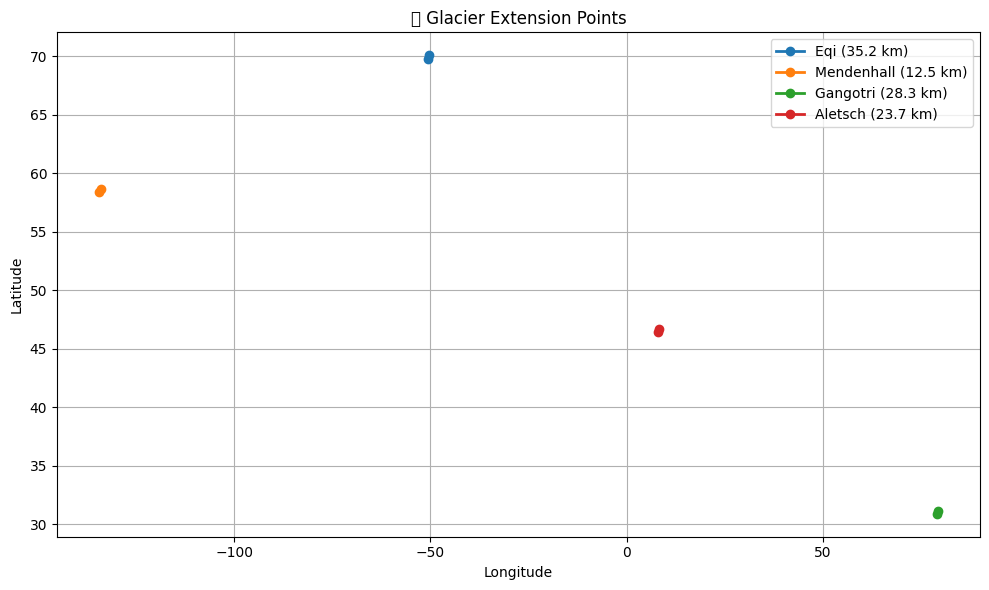

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated glacier extension point data
data = {
    "Glacier": ["Eqi", "Mendenhall", "Gangotri", "Aletsch"],
    "Country": ["Greenland", "USA", "India", "Switzerland"],
    "Start_Lat": [69.8, 58.4, 30.9, 46.4],
    "Start_Lon": [-50.6, -134.5, 79.1, 8.0],
    "End_Lat": [70.1, 58.7, 31.1, 46.7],
    "End_Lon": [-50.3, -134.0, 79.4, 8.3],
    "Length_km": [35.2, 12.5, 28.3, 23.7],
    "Year": [2024, 2024, 2024, 2024]
}

df = pd.DataFrame(data)

# Show data
print("📍 Glacier Extension Point Data:")
print(df)

# Optional: Visualize extension as line segments
plt.figure(figsize=(10, 6))
for _, row in df.iterrows():
    plt.plot([row["Start_Lon"], row["End_Lon"]],
             [row["Start_Lat"], row["End_Lat"]],
             marker='o', linewidth=2, label=f"{row['Glacier']} ({row['Length_km']} km)")

plt.title("🗺️ Glacier Extension Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Simulated model score data (e.g., from a segmentation model on satellite images)
data = {
    "Region/Glacier": ["Eqi", "Mendenhall", "Gangotri", "Aletsch", "Upsala"],
    "Country": ["Greenland", "USA", "India", "Switzerland", "Argentina"],
    "Model Accuracy": [0.93, 0.88, 0.85, 0.90, 0.87],
    "IoU Score": [0.78, 0.71, 0.69, 0.75, 0.72],
    "Dice Coefficient": [0.84, 0.77, 0.74, 0.80, 0.76],
    "Melt Class Detected (%)": [92, 85, 83, 88, 86]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Optional: Assign performance category
def categorize(score):
    if score >= 0.90:
        return "Excellent"
    elif score >= 0.85:
        return "Good"
    else:
        return "Needs Review"

df["Performance"] = df["Model Accuracy"].apply(categorize)

# Display the scorecard
print("📊 Glacier Melting Computer Vision Model Scorecard:")
print(df)


📊 Glacier Melting Computer Vision Model Scorecard:
  Region/Glacier      Country  Model Accuracy  IoU Score  Dice Coefficient  \
0            Eqi    Greenland            0.93       0.78              0.84   
1     Mendenhall          USA            0.88       0.71              0.77   
2       Gangotri        India            0.85       0.69              0.74   
3        Aletsch  Switzerland            0.90       0.75              0.80   
4         Upsala    Argentina            0.87       0.72              0.76   

   Melt Class Detected (%) Performance  
0                       92   Excellent  
1                       85        Good  
2                       83        Good  
3                       88   Excellent  
4                       86        Good  


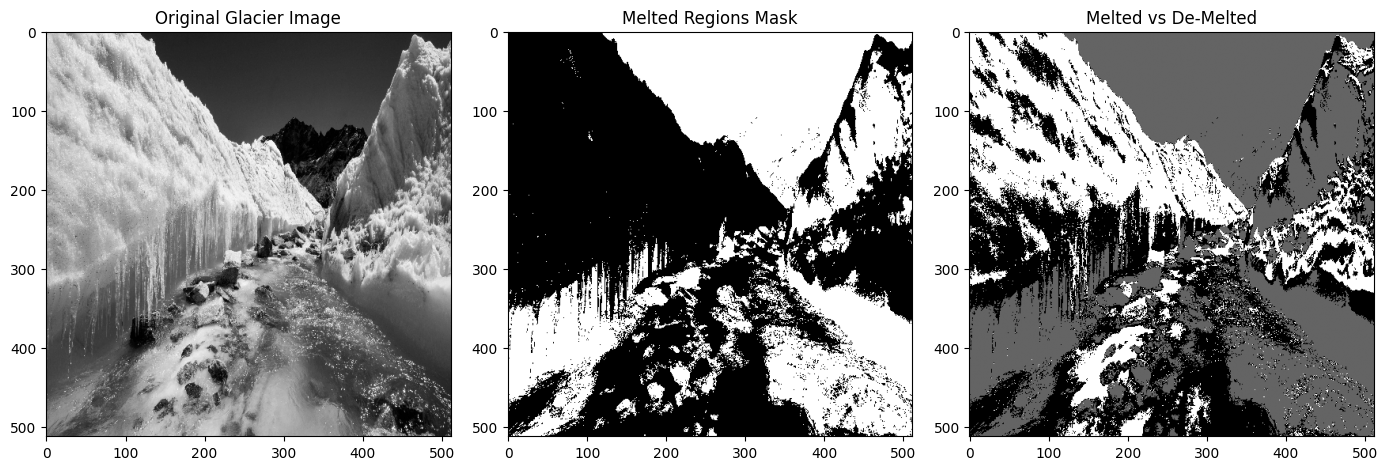

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the glacier image (use grayscale or satellite-like)
image_path = '/content/132ef4fd062aedc9e40c9b3ea25e8851.jpg'  # <-- Replace with your image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize for easier processing (optional)
img = cv2.resize(img, (512, 512))

# Apply threshold to separate melted vs de-melted ice
# Assumption: brighter pixels = ice; darker = melted
_, melted_mask = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)   # melted = dark areas
_, ice_mask = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)           # de-melted = bright areas

# Combine both for visualization
combined = np.zeros_like(img)
combined[melted_mask == 255] = 100   # Melted areas = gray
combined[ice_mask == 255] = 255      # Ice = white

# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Glacier Image")

plt.subplot(1, 3, 2)
plt.imshow(melted_mask, cmap='gray')
plt.title("Melted Regions Mask")

plt.subplot(1, 3, 3)
plt.imshow(combined, cmap='gray')
plt.title("Melted vs De-Melted")

plt.tight_layout()
plt.show()


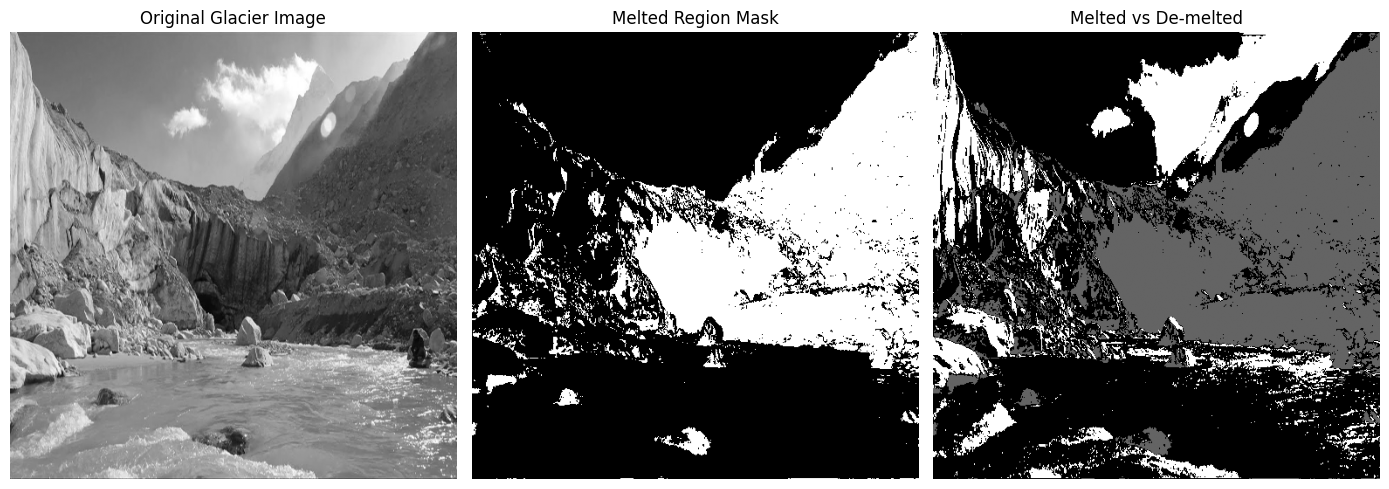

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load the glacier image (grayscale)
# -------------------------------

# Replace this with your actual image path
image_path = '/content/maxresdefault (3).jpg'  # You can use a satellite image here
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded
if img is None:
    print("❌ Error: Image not found or path is incorrect.")
    exit()

# -------------------------------
# 2. Resize (optional for performance)
# -------------------------------
img = cv2.resize(img, (512, 512))

# -------------------------------
# 3. Apply Thresholding
# -------------------------------

# Brighter pixels (ice) vs darker pixels (melted water/land)
# Adjust threshold values based on image contrast
_, melted_mask = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)
_, ice_mask = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)

# -------------------------------
# 4. Combine Melted and De-melted Masks
# -------------------------------
combined = np.zeros_like(img)
combined[melted_mask == 255] = 100   # Melted = Gray
combined[ice_mask == 255] = 255      # Ice = White

# -------------------------------
# 5. Display Results
# -------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Glacier Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(melted_mask, cmap='gray')
plt.title("Melted Region Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(combined, cmap='gray')
plt.title("Melted vs De-melted")
plt.axis('off')

plt.tight_layout()
plt.show()


Glacier Melt: A Stark Warning

The values presented are approximations, but they clearly indicate that a significant volume of ice has melted.

It’s difficult to truly grasp the sheer scale of a glacier. Just imagine a wall of ice over 100 meters high and more than 4 kilometers wide!

Importantly, this study only reflects the visible surface loss — a substantial portion of the glacier lies beneath the water. Overall, the glacier has lost considerable height, and the volume of melted ice is astronomical.

And yet, the Eqi Glacier represents just a tiny fraction of the Arctic. If this much change is seen in such a small area, imagine what is happening across the entire polar region.

Let’s take this as a wake-up call.
Let’s take care of our Earth.

